In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import requests, zipfile, io
import matplotlib.pyplot as plt

from matplotlib.image import imread
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

# Data

In [ ]:
# Download and extract the zip file

zip_file_url = 'https://moncoachdata.com/wp-content/uploads/cell_images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Path to the cell_images folder
my_data_dir = 'cell_images'

print(os.listdir(my_data_dir) )

test_path  = my_data_dir + '/test/'
train_path = my_data_dir + '/train/'

os.listdir(test_path), os.listdir(train_path + 'parasitized')[0]

['test', 'train']


(['uninfected', 'parasitized'],
 'C144P105ThinF_IMG_20151015_155004_cell_312.png')

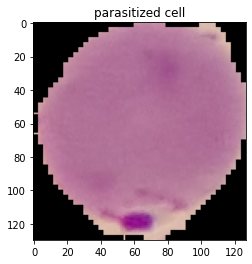

((130, 127, 3), (115, 118, 3))

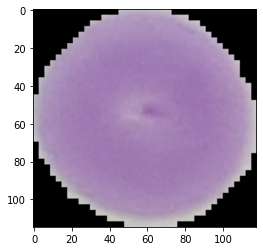

In [ ]:
para_img = imread(train_path + '/parasitized' + '/C59P20thinF_IMG_20150803_113809_cell_41.png')

plt.title("parasitized cell")
plt.imshow(para_img)
plt.show()

unifected_cell = imread(train_path + 'uninfected/' + os.listdir(train_path+'/uninfected')[0])
plt.imshow(unifected_cell)

para_img.shape, unifected_cell.shape

In [ ]:
# Number of parasitized images, Number of uninfected images 
len(os.listdir(train_path+'parasitized')), len(os.listdir(train_path+'uninfected'))

(12480, 12480)

In [ ]:
# Number of parasitized images, Number of uninfected images 
len(os.listdir(test_path + 'parasitized')), len(os.listdir(test_path + 'uninfected'))

(1300, 1300)

# Preprocessing the images in Tensorflow

In [ ]:
image_shape = (130 ,130, 3)
batch_size = 16

image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, # Change the width of the photo by up to 10%.
                               height_shift_range=0.1, # Change the height of the photo by up to 10%.
                               # rescale=1/255, # Resize the image by normalising it
                               shear_range=0.1, # shear means to cut a part of the image (max 10%)
                               zoom_range=0.1, # Zoom the 10% maximum
                               horizontal_flip=True, # Allows horizontal tilting
                               fill_mode='nearest' # Fill in the missing pixels with the nearest filled value
                              )

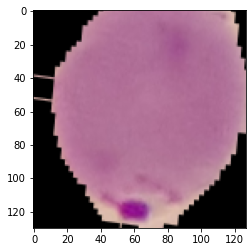

In [ ]:
para_cell = train_path + '/parasitized' + '/C59P20thinF_IMG_20150803_113809_cell_41.png'
para_img = imread(para_cell)

# Take a random transformation from image_gen
plt.imshow(image_gen.random_transform(para_img));

In [ ]:
train_path

'cell_images/train/'

In [ ]:
# Mandatory organisation into subdirectories to let the function flow_from_directory work

# Dataset
# Class 1: 0.jpg, 1.jpg..
# Class 2: 0.jpg, 1.jpg..

train_image_gen = image_gen.flow_from_directory(train_path,
                                              target_size=image_shape[:2], # 130, 130,
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=False)

train_image_gen.class_indices

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


{'parasitized': 0, 'uninfected': 1}

# Model 

In [ ]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
image_shape = (130,130,3)
batch_size = 16

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

early_stop = EarlyStopping(monitor='val_loss',patience=2)

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
model.fit(train_image_gen,epochs=1, validation_data=test_image_gen, callbacks=[early_stop])

1560/1560 [==============================] - 673s 431ms/step - loss: 0.9072 - accuracy: 0.5450 - val_loss: 0.6811 - val_accuracy: 0.5612


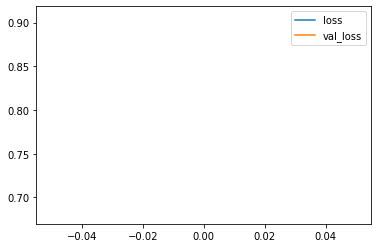

163/163 [==============================] - 26s 156ms/step - loss: 0.6817 - accuracy: 0.5742


[0.6816546320915222, 0.5742307901382446]

In [ ]:
losses = pd.DataFrame(model.history.history)

losses[['loss','val_loss']].plot()
plt.show()

model.evaluate(test_image_gen)

# Predict

In [ ]:
pred_probabilities = model.predict(test_image_gen)
predictions = pred_probabilities > 0.5
predictions

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [16]:
confusion_matrix(test_image_gen.classes,predictions)

array([[626, 674],
       [474, 826]])

In [17]:
my_image = image.load_img(para_cell,target_size=image_shape)

my_image = image.img_to_array(my_image)

print(my_image.shape)
my_image = np.expand_dims(my_image, axis=0)

print(my_image.shape)

(model.predict(my_image) > 0.5).astype('int32') # 0: parasitized

(130, 130, 3)
(1, 130, 130, 3)


array([[1]], dtype=int32)